In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.datasets import load_diabetes, load_digits, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, log_loss

# Lineare Regression

## Daten und Vorbereitung

Datensatz zur Vorhersage von Blutzuckerwerten (Diabetes mellitus) laden:

In [ ]:
diabetes = load_diabetes()
diabetes.data.shape

Beispiel: die ersten 10 Datenpunkte

In [ ]:
print(diabetes.feature_names)
print(np.round(diabetes.data[:10, :], 3))
print("Zielvariable:", diabetes.target[:10])

Daten sind bereits standardisiert (mit $\mu = 0$ und $\sigma = \sqrt{1 / n}$).

In [ ]:
print(np.round(diabetes.data.mean(axis=0), 5))
print(diabetes.data.std(axis=0))

Aufteilung in Trainings- und Testdaten, wobei durch `random_state` die Replizierbarkeit sichergestellt wird (aber probieren Sie auch andere Werte für `random_state` aus!).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    diabetes.data, diabetes.target, test_size=0.5, random_state=666)

## Regression mit Scikit-Learn

Zur Kontrolle führen wir eine lineare Regression mit Scikit-Learn durch: unsere Ergebnisse sollten ähnlich sein (sowohl bzgl. der Vorhersagegüte als auch vergleichbare Parameterwerte).

In [ ]:
model = LinearRegression().fit(X_train, y_train)
model.score(X_test, y_test) # R2 = Anteil der Varianz

Intuitives Gütemaß für die Regressionsvorhersagen ist unser Loss: _mean squared error_ (MSE). Zur besseren Interpretierbarkeit verwenden wir hier _root mean squared error_ (rMSE), das die gleiche Skalierung wie die Zielvariable hat.

In [ ]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

Modellparameter:

In [ ]:
print(np.round(model.coef_, 1))       # w
print(np.round(model.intercept_, 1))  # b

Wir können auch die Korrelation zwischen den vorhergesagten Werten des Modells und dem Gold Standard visualisieren:

In [ ]:
plt.scatter(y_pred, y_test)
plt.xlabel("predicted")
plt.ylabel("true value");

Zum Vergleich berechnen wir rMSE auf den Trainingsdaten: gibt es Anzeichen für Überanpassung?

In [ ]:
mean_squared_error(y_train, model.predict(X_train), squared=False)

> **Aufgabe:**  Probieren Sie alternativ _Ridge Regression_ aus (`Ridge`), das die lineare Regression mit einer Regularisierung kombiniert. Wie verändern sich dabei die Lernergebnisse?

## Eigene Implementierung des Regressionsmodells

Wir implementieren unser Modell als Python-Klasse, um die Parameter $\mathbf{w}$ und $b$ zusammenzufassen und die wichtigsten Methoden bereitzustellen. Dabei können wir im wesentlichen die Formeln aus der Vorlesung abtippen und verwenden auch weitgehend die dort eingeführten Bezeichnungen.

Im Gegensatz zum SKLTagger ist hier nicht beabsichtigt, die API von Scikit-Learn anzubieten. Auch auf eine Fehlerbehandlung verzichten wir der Übersichtlichkeit zuliebe.

In [ ]:
class Linear:
    def __init__(self, d):
        self.dim = d
        self.w = np.zeros(d)
        self.b = 0.0
    
    def f(self, X):
        return np.dot(X, self.w) + self.b
    
    def predict(self, X):
        return self.f(X)
    
    def loss(self, X, y):
        z = self.f(X)
        return np.square(y - z).mean()

    def score(self, X, y):
        return np.sqrt(self.loss(X, y))
    
    def grad(self, X, y):
        z = self.f(X)
        n = y.shape[0]
        grad_b = -2.0 * np.sum(y - z) / n
        grad_w = -2.0 * np.dot(y - z, X) / n
        return (grad_w, grad_b)

Zum Testen fügen wir einfach die Parameter des Scikit-Learn-Modells ein:

In [ ]:
linear = Linear(10)
linear.w = model.coef_
linear.b = model.intercept_

Damit können wir Vorhersagen für die Testdaten berechnen und mit dem Scikit-Learn-Modell sowie den tatsächlichen Werten vergleichen:

In [ ]:
tmp = np.vstack([
    linear.predict(X_test),
    model.predict(X_test),
    y_test
])
print(np.round(tmp[:, 0:10], 1))

Auch unsere Loss-Funktion $L(\mathbf{w}, b; T)$ sollte mit dem oben berechneten rMSE übereinstimmen.

In [ ]:
np.sqrt(linear.loss(X_test, y_test))

Berechnung des Gradienten bzgl. der Testdaten:

In [ ]:
[np.round(x, 3) for x in linear.grad(X_test, y_test)]

Warum ist der folgende Gradient = 0?

In [ ]:
[np.round(x, 3) for x in linear.grad(X_train, y_train)]

## Der Gradient Descent-Algorithmus

Wir beginnen mit einer naiven Implementierung des Gradient Descent-Verfahrens. Der Algorithmus ist eigentlich unabhängig vom zugrundeliegenden Vorhersagemodell und würde im Prinzip mit jeder Klasse funktionieren, die dieselbe Schnittstelle wie unsere `Linear`-Klasse bereitstellt. Der Einfachheit halber sind die Parameter $\mathbf{w}, b$ fest im Programm verdrahtet, so dass nur Modelle mit diesen Parametern verwendet werden können. Das umfasst aber immerhin auch die logistische Regression.

> **Aufgabe:** Implementieren Sie die einfachste Variante eines Gradient Descent-Verfahrens. Ein Vorschlag für die Signatur der zu schreibenden Funktion ist unten vorgegeben. Sie sollte folgendermaßen ablaufen:
>   - `model` muss ein neu initialisiertes Objekt einer geeigneten Klasse sein (nicht `linear` von oben!)
>   - in jedem Schritt wird zunächst der Loss auf den Trainingsdaten berechnet und ausgegeben (sowie optional auch ein Evaluationsergebnis auf den Testdaten `validation_data=(X_test, y_test)`)
>   - dann wird der Gradient berechnet, mit der Lernrate $\lambda$ mutlipliziert und damit die Parameterwerte von `model` aktualisiert
>   - das Verfahren läuft immer für die übergebene Anzahl von `max_steps`, so dass Sie keine Konvergenzprüfung vornehmen müssen

In [1]:
def gradient_descent(model, X, y, learning_rate=.1, max_steps=42, validation_data=None):
    pass

Zum Testen Ihres Verfahrens trainieren Sie ein lineares Modell auf dem Trainingsdatensatz und vergleichen es mit den oben gezeigten Ergebnissen.

In [ ]:
linear_gd = Linear(10) # immer neu initialisieren!
gradient_descent(linear_gd, X_train, y_train, validation_data=(X_test, y_test))

Falls das Verfahren in der vorgegebenen Anzahl Schritte konvergiert, sollten die Parameterwerte ungefähr mit dem Scikit-Learn-Modell übereinstimmen.

In [ ]:
print(np.round(linear_gd.w, 1))
print(np.round(linear_gd.b, 1))

> **Aufgabe:** Verbessern Sie Ihre Implementierung von Gradient Descent, indem Sie etwa
>   - den Algorithmus beenden, wenn der Loss auf den Trainingsdaten konvergiert
>   - automatisch die Lernrate anpassen (z.B. nach einer bestimmten Zahl Schritte halbieren)
>   - GD mit Momentum implementieren
>   - eine optionale Regularisierung ermöglichen (am besten mit $L_2$-Penalty, so dass $\nabla C(\mathbf{w})$ leicht zu berechnen ist)

# Logistische Regression

## Daten und Vorbereitung

Wir arbeiten hier einen kleinen Beispieldatensatz handschriftlicher Ziffern, der in Scikit-Learn enthalten ist und nur eine Auflösung von $8\times 8$ Pixeln verwendet.  Zur Vereinfachung wollen wir nur die **Ziffern 0** und **1** unterscheiden, so dass wir die Aufgabe als binäres Klassifikationsproblem behandeln und die logistische Regression direkt anwenden können.

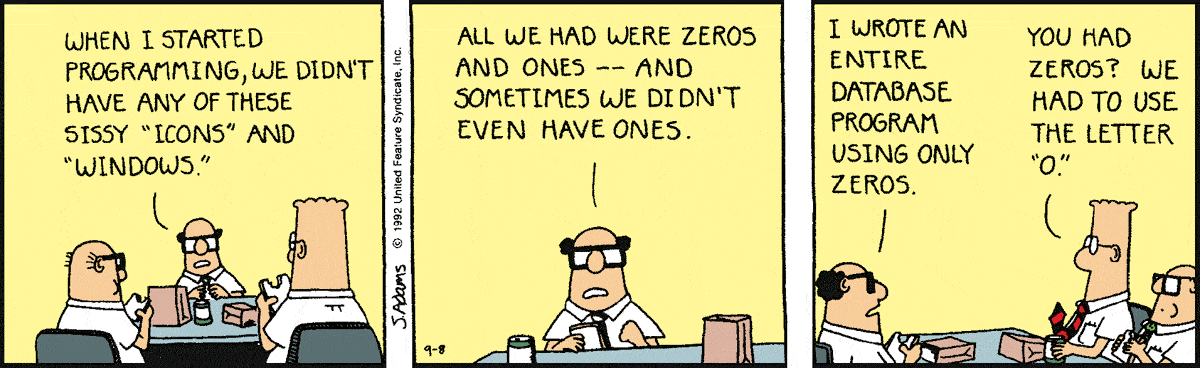

Der Datensatz enthält jeweils 180 Beispiele für die Ziffern 0 und 1. Sie sind als flache Merkmalsvektoren $\mathbf{x}_i \in \mathbb{R}^64$ und alternativ auch als $8\times 8$-Matrizen bereitgestellt.

In [3]:
digits = load_digits(n_class=2)
print(digits.data.shape)
print(digits.images.shape)

(360, 64)

Visualisierung und zugehörige Zielvariablen:

[0 1 0 1 0 1 0 0]


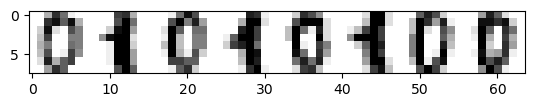

In [17]:
plt.imshow(np.hstack(digits.images[0:8]), cmap="binary")
print(digits.target[0:8])

Die Pixelwerte sind als Graustufen zwischen 0 und 16 angegeben. Wir skalieren sie unten auf den Wertebereich $[0, 1]$.

Aufteilung in Trainings- und Testdaten. Wir verwenden Variablennamen `XX_*` und `yy_*` um die Daten für die lineare Regression aus dem ersten Teil der Übung nicht zu überschreiben.

In [22]:
XX_train, XX_test, yy_train, yy_test = train_test_split(
    digits.data / 16.0, digits.target, test_size=0.5, random_state=666)

## Logistische Regression mit Scikit-Learn

Zur Kontrolle trainieren wir wiederum ein Scikit-Learn-Modell. Da es im Gegensatz zur linearen Regression keine exakte Lösung gibt, die direkt berechnet werden kann, müssen wir damit rechnen, dass das iterative Optimierungsverfahren von Scikit-Learn zu leicht anderen Ergebnissen kommt als unsere Implementierung.

In [41]:
model = LogisticRegression(penalty='l2').fit(XX_train, yy_train)
model.score(XX_test, yy_test)

1.0

Die Aufgabenstellung ist offensichtlich so einfach (auch aufgrund der extrem ähnlichen Schreibung der Ziffern), dass auch mit diesem kleinen Trainingsdatensatz eine perfekte Klassifikation gelernt werden kann.

In [44]:
yy_pred = model.predict(XX_test)
print(classification_report(yy_test, yy_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00        91

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



Idealerweise sollte unsere Implementierung der logistischen Regression ähnliche Merkmalsgewichte lernen. Wir können diese sogar visualisieren und sehen dabei eine intuitiv gut nachvollziehbare Verteilung.

[[ 0.    0.   -0.06 -0.52 -0.29  0.58  0.23  0.  ]
 [ 0.   -0.01 -0.56 -0.23  0.14 -0.19  0.17  0.  ]
 [ 0.02  0.15 -0.41  0.82  1.09 -0.38 -0.11  0.  ]
 [ 0.01 -0.09 -0.27  0.85  1.06 -0.21 -0.49  0.  ]
 [ 0.   -0.47 -0.62  0.87  1.08 -0.27 -0.55  0.  ]
 [ 0.   -0.23 -0.81  0.56  0.8  -0.5  -0.44  0.  ]
 [ 0.   -0.04 -0.7  -0.17 -0.04 -0.48  0.08  0.06]
 [ 0.    0.   -0.07 -0.54 -0.24  0.42  0.41  0.13]]


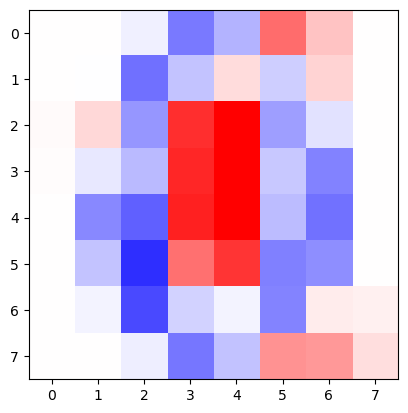

In [57]:
weights = model.coef_[0].reshape((8, 8))
plt.imshow(weights, cmap="bwr", vmin=-1, vmax=1)
print(np.round(weights, 2))

## Eigene Implementierung der logistischen Regression

> **Aufgabe:** Implementieren Sie den Klassifikationsalgorithmus der (binären) logistischen Regression als Klasse `Logistic`.
>   - Stellen Sie dabei dieselben Methoden zur Verfügung wie in der Klasse `Linear` für lineare Regression.
>   - Beachten Sie, dass die Zielkategorien wie üblich als Werte 0 (negativ) und 1 (positiv) angegeben werden. Übersetzen Sie diese intern in $-1$ und $+1$, um die Formeln aus der Vorlesung anwenden zu können.
>   - Es könnte nützlich sein, zusätzlich eine Methode `predict_proba()` zu implementieren, die die Wahrscheinlichkeit für die positive Klasse zurückliefert.

> **Aufgabe:** Testen Sie Ihre Implementierung, indem Sie wie im ersten Teil der Übung die vom Scikit-Learn-Modell gelernten Parameter in Ihr Objekt einfügen und es dann auf den Testdatensatz anwenden. Berechnen Sie auch den Gradienten für die Trainingsdaten.

## Gradient Descent für die logistische Regression

Ihre Implementierung des Gradient Descent-Algorithmus aus dem ersten Teil sollte auch mit der Klasse `Logistic` funktionieren.

> **Aufgabe:** Trainieren Sie Ihr Modell mit der Funktion `gradient_descent()` und evaluieren Sie es auf den Testdaten.
>   - Sind die Ergebnisse ähnlich gut wie mit Scikit-Learn?
>   - Warum konvergiert das Modell ohne Regularisierung nicht, auch wenn es auf den Testdaten schon eine perfekte Klassifikation erreicht?

In [ ]:
logistic = Logistic(64)
# - Modell trainieren
# - Modell evaluieren

> **Aufgabe:** Wenn Sie mit den Lernergebnissen zufrieden sind, können Sie die gelernten Parameter jetzt auch visualisieren.

## Freiwillige Zusatzaufgaben

Bearbeiten Sie eine der folgenden Zusatzaufgaben (oder beide).

> **Aufgabe:** Implementieren Sie _Stochastic Gradient Descent_.
>   - Ergänzen Sie dazu Ihre Funktion `gradient_descent()` um eine innere Schleife, die für jede Epoche den Trainingsdatensatz in eine wählbare Anzahl von Mini-Batches aufteilt.
>   - Der Parameter `max_steps` gibt nun die maximale Anzahl von Epochen vor. Bildschirmausgaben und Konvergenzprüfung sollten nur am Ende jeder vollständigen Epoche erfolgen.
>   - Achten Sie darauf, die Trainingsdaten zu Beginn jeder Epoche zufällig umzusortieren (ggf. durch Parameter wählbar).
>   - Trainieren Sie das Modell wie oben und vergleichen Sie die gefundenen Merkmalsgewichte.

> **Aufgabe:** Testen Sie Ihr Modell mit dem schwierigeren MNIST-Datensatz.
>   - Laden Sie die MNIST-Daten und reduzieren Sie sie auf die Ziffern 0 und 1.
>   - Trainieren Sie logistische Regression mit Scikit-Learn und Ihrer eigenen Implementierung.
>   - Vergleichen Sie die Evaluationsergebnisse. Wie schnell konvergiert Ihr Lernverfahren?
>   - Visualisieren Sie die gelernten Merkmalsgewichte.
>   - Bei dieser Aufgabe könnte sich Stochastic Gradient Descent als nützlich erweisen.

In [59]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)